# Neural Network Training

In [1]:
# imports
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
import tqdm

import numpy as np
import jax.numpy as jnp
import torch.optim as optim

from extravaganza.dynamical_systems import LinearRegression, MNIST

from extravaganza.observables import TimeDelayedObservation, FullObservation, Trajectory
from extravaganza.sysid import Lifter, LiftedController, OfflineSysid
from extravaganza.controllers import LQR, HINF, BPC, GPC, RBPC, EvanBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG, FIXED_RESCALE
from extravaganza.stats import Stats
from extravaganza.utils import ylim, render, append, opnorm, dare_gain, least_squares
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = 9  # need a seed so that we generate the same linreg dataset each time
CONTROLLER_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmp33fztc6g
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmp33fztc6g/_remote_module_non_scriptable.py


## System
Here, we tune the parameters of a gradient descent algorithm training a neural network. We can train either a linear regression or an MLP or CNN MNIST model. Any optimizer can be used, such as `SGD` or `Adam`, and any parameter can be tuned, such as `lr` or `momentum`. 

Which optimizer to use is specified in the `make_optimizer` argument, and how to update and tune things is specified in the `apply_control` argument.

At the moment, we apply a 2-dimensional control $u = (u_0, u_1)$ that dictates 2 parameters of the learning rate schedule, given as
$$\eta_t := \frac{u_0}{1 + u_1 \cdot \sqrt{t}},$$
where $u_0$ is the initial learning rate and $u_1$ is a decay rate.

## Hyperparameters

In [10]:
name = 'nn'
filename = '../logs/{}.pkl'.format(name)

def get_experiment_args():
    # --------------------------------------------------------------------------------------
    # ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    num_trials = 1
    T = 10000  # total timesteps
    T0 = 5000  # number of timesteps to just sysid for our methods
    reset_condition = lambda t: t % 1000 == 0  # when to reset the system (which means fresh LR/MNIST model params)
    use_multiprocessing = False  # unsure if this works in jupyter notebooks
    render_every = None

    # --------------------------------------------------------------------------------------
    # --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
    # --------------------------------------------------------------------------------------

    initial_lr = 0.1
    initial_decay = 0.2
    initial_control = jnp.array([initial_lr, initial_decay])
    du = initial_control.shape[0]
    
    make_optimizer = lambda model: optim.SGD(model.parameters(), lr=initial_lr)
    def apply_control(control, system): system.opt.param_groups[0]['lr'] = max(0, control[0].item()) / (1 + max(0., control[1].item()) * system.episode_t ** 0.5)

#     make_system = lambda : LinearRegression(make_optimizer, apply_control,
#                                             dataset = 'generated', 
#                                             repeat = 3,
#                                             eval_every = 1, seed=SYSTEM_SEED)   

    make_system = lambda : MNIST(make_optimizer, apply_control,
                                 model_type = 'MLP', batch_size = 64,
                                 repeat = 5,
                                 eval_every=None, seed=SYSTEM_SEED)   # best is something like (0.5, 0.05) or (0.2, 0)
    observable = TimeDelayedObservation(hh = 3, control_dim=du, time_embedding_dim=8,
                                        use_states=False, use_costs=True, use_controls=True, use_time=True)
    do = observable.obs_dim  # dimension of observations to lift from

    # --------------------------------------------------------------------------------------
    # ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    dl = 32  # dimension of state to lift to
    
    sysid_args = {
        'obs_dim': do,
        'control_dim': du,
        'initial_control': initial_control,

        'max_traj_len': int(1e6),
        
        # define the sysid search space, which is centered around `initial_control`
        'exploration_scales': (0.4, 0.2),
        'exploration_bounds': ((0., 1.),
                               (0., 0.5)),

        'depth': 6,
        'sigma': 0,  # inject noise
        'determinstic_encoder': True,  # whether to use VAE-type encoder or not
        'num_epochs': 500,
        'batch_size': 32,
        'lifter_lr': 0.002,                                                           
        'sysid_lr': 0.002,

        'seed': SYSID_SEED,
    }

    # --------------------------------------------------------------------------------------
    # ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    h = 5 # controller memory length (# of w's to use on inference)
    m_update_rescaler = lambda : ADAM(alpha=0.00, betas=(0.9, 0.99), use_bias_correction=True)
    m0_update_rescaler = lambda : ADAM(alpha=0.004, betas=(0.9, 0.99), use_bias_correction=True)
    k_update_rescaler = lambda : ADAM(alpha=0.001, betas=(0.9, 0.99), use_bias_correction=True)
#     m_update_rescaler = lambda : FIXED_RESCALE(alpha=0.0)
#     m0_update_rescaler = lambda : FIXED_RESCALE(alpha=0.01)
#     k_update_rescaler = lambda : FIXED_RESCALE(alpha=0.0)

    bpc_args = {
        'h': h,  
        'method': 'REINFORCE',
        'initial_scales': (0., 0.05, 0.),  # M, M0, K   (uses M0's scale for REINFORCE)
        'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
#         'bounds': ([0, 0], [1, 1]),
        'initial_u': initial_control,
        'decay_scales': False,
        'use_tanh': False,  # dont
        'use_stabilizing_K': False,
        'seed': CONTROLLER_SEED
    }

    # this is a bit of a mess at the minute, but here goes: 
    #         - `OfflineSysid` is a wrapper to do sysid phase followed by control,
    #         - `LiftedController` is a wrapper that lifts states before passing to the controller, and 
    #         - `EvanBPC` is the controller (can be replaced with `extravaganza.controllers.RBPC` as well)
    # I currently use lambdas as object generators to make them from scratch easily, but soon i will switch to actual
    # generators or using deepcopies or something :)
    
    make_controllers = {
#         '{}/{}'.format(*[round(v.item(), 2) for v in initial_control]): lambda sys: ConstantController(initial_control, do),
#         'Linear': lambda sys: OfflineSysid(lambda sysid: LiftedController(EvanBPC(sysid.A, sysid.B, **bpc_args), sysid), 
#                                                                             sysid=Lifter(method='identity', state_dim=do, **sysid_args), T0=T0),
#         'Koopman': lambda sys: OfflineSysid(lambda sysid: LiftedController(EvanBPC(sysid.A, sysid.B, **bpc_args), sysid), 
#                                                                             sysid=Lifter(method='fourier', state_dim=dl, **sysid_args), T0=T0),
        'NN': lambda sys: OfflineSysid(lambda sysid: LiftedController(EvanBPC(sysid.A, sysid.B, **bpc_args), sysid), 
                                                                            sysid=Lifter(method='nn', state_dim=dl, **sysid_args), T0=T0),
    }
    experiment_args = {    
        'make_system': make_system,
        'make_controllers': make_controllers,
        'observable': observable,
        'num_trials': num_trials,
        'T': T,
        'reset_condition': reset_condition,
        'reset_seed': None,
        'use_multiprocessing': use_multiprocessing,
        'render_every': render_every,
    }
    return experiment_args

## actually run the thing :)

In [11]:
# run
experiment = Experiment(name)
stats = experiment(get_experiment_args)

INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing NN
 50%|███████████████████████████████▍                               | 4996/10000 [02:14<02:11, 38.18it/s, control=[0.18748716 0.2584481 ], cost=0.14]INFO: (SYSID WRAPPER) ending exploration at timestep 5000
INFO: (LIFTER): ending sysid phase at step 4999
INFO: training!
INFO: mean loss for epochs -25 - 0 was {'linearization': 1.3954980979691847e-05, 'cpc': 3.4932620525360107, 'consistency': 0.0, 'simplification': 0.10490078942324871, 'residual centeredness': 3.9322048884252545e-07, 'centeredness': 0.14340424014685246}
INFO: mean loss for epochs 0 - 25 was {'linearization': 0.00024159939596453718, 'cpc': 1.354513884018629, 'consistency': 0.0, 'simplification': 0.15834707237971132, 'residual centeredness': 1.1725366097495317e-05, 'centeredness': 0.002

||A||_op = 0.9955793023109436
||B||_F = 0.4540158808231354
||A-BK||_op = 0.9956412315368652


100%|████████████████████████████████████████████████████████████| 10000/10000 [06:48<00:00, 24.45it/s, control=[0.3687098  0.43462843], cost=0.0507]
INFO: 
INFO: (EXPERIMENT) done! The entire experiment took 409.0637176251039 seconds


In [12]:
# save args and stats!  --  note that to save the args, we actually save the `get_args` function. we can print the 
#                           source code later to see the hyperparameters we chose
# experiment.save(filename)

## Visualization
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

<Figure size 640x480 with 0 Axes>

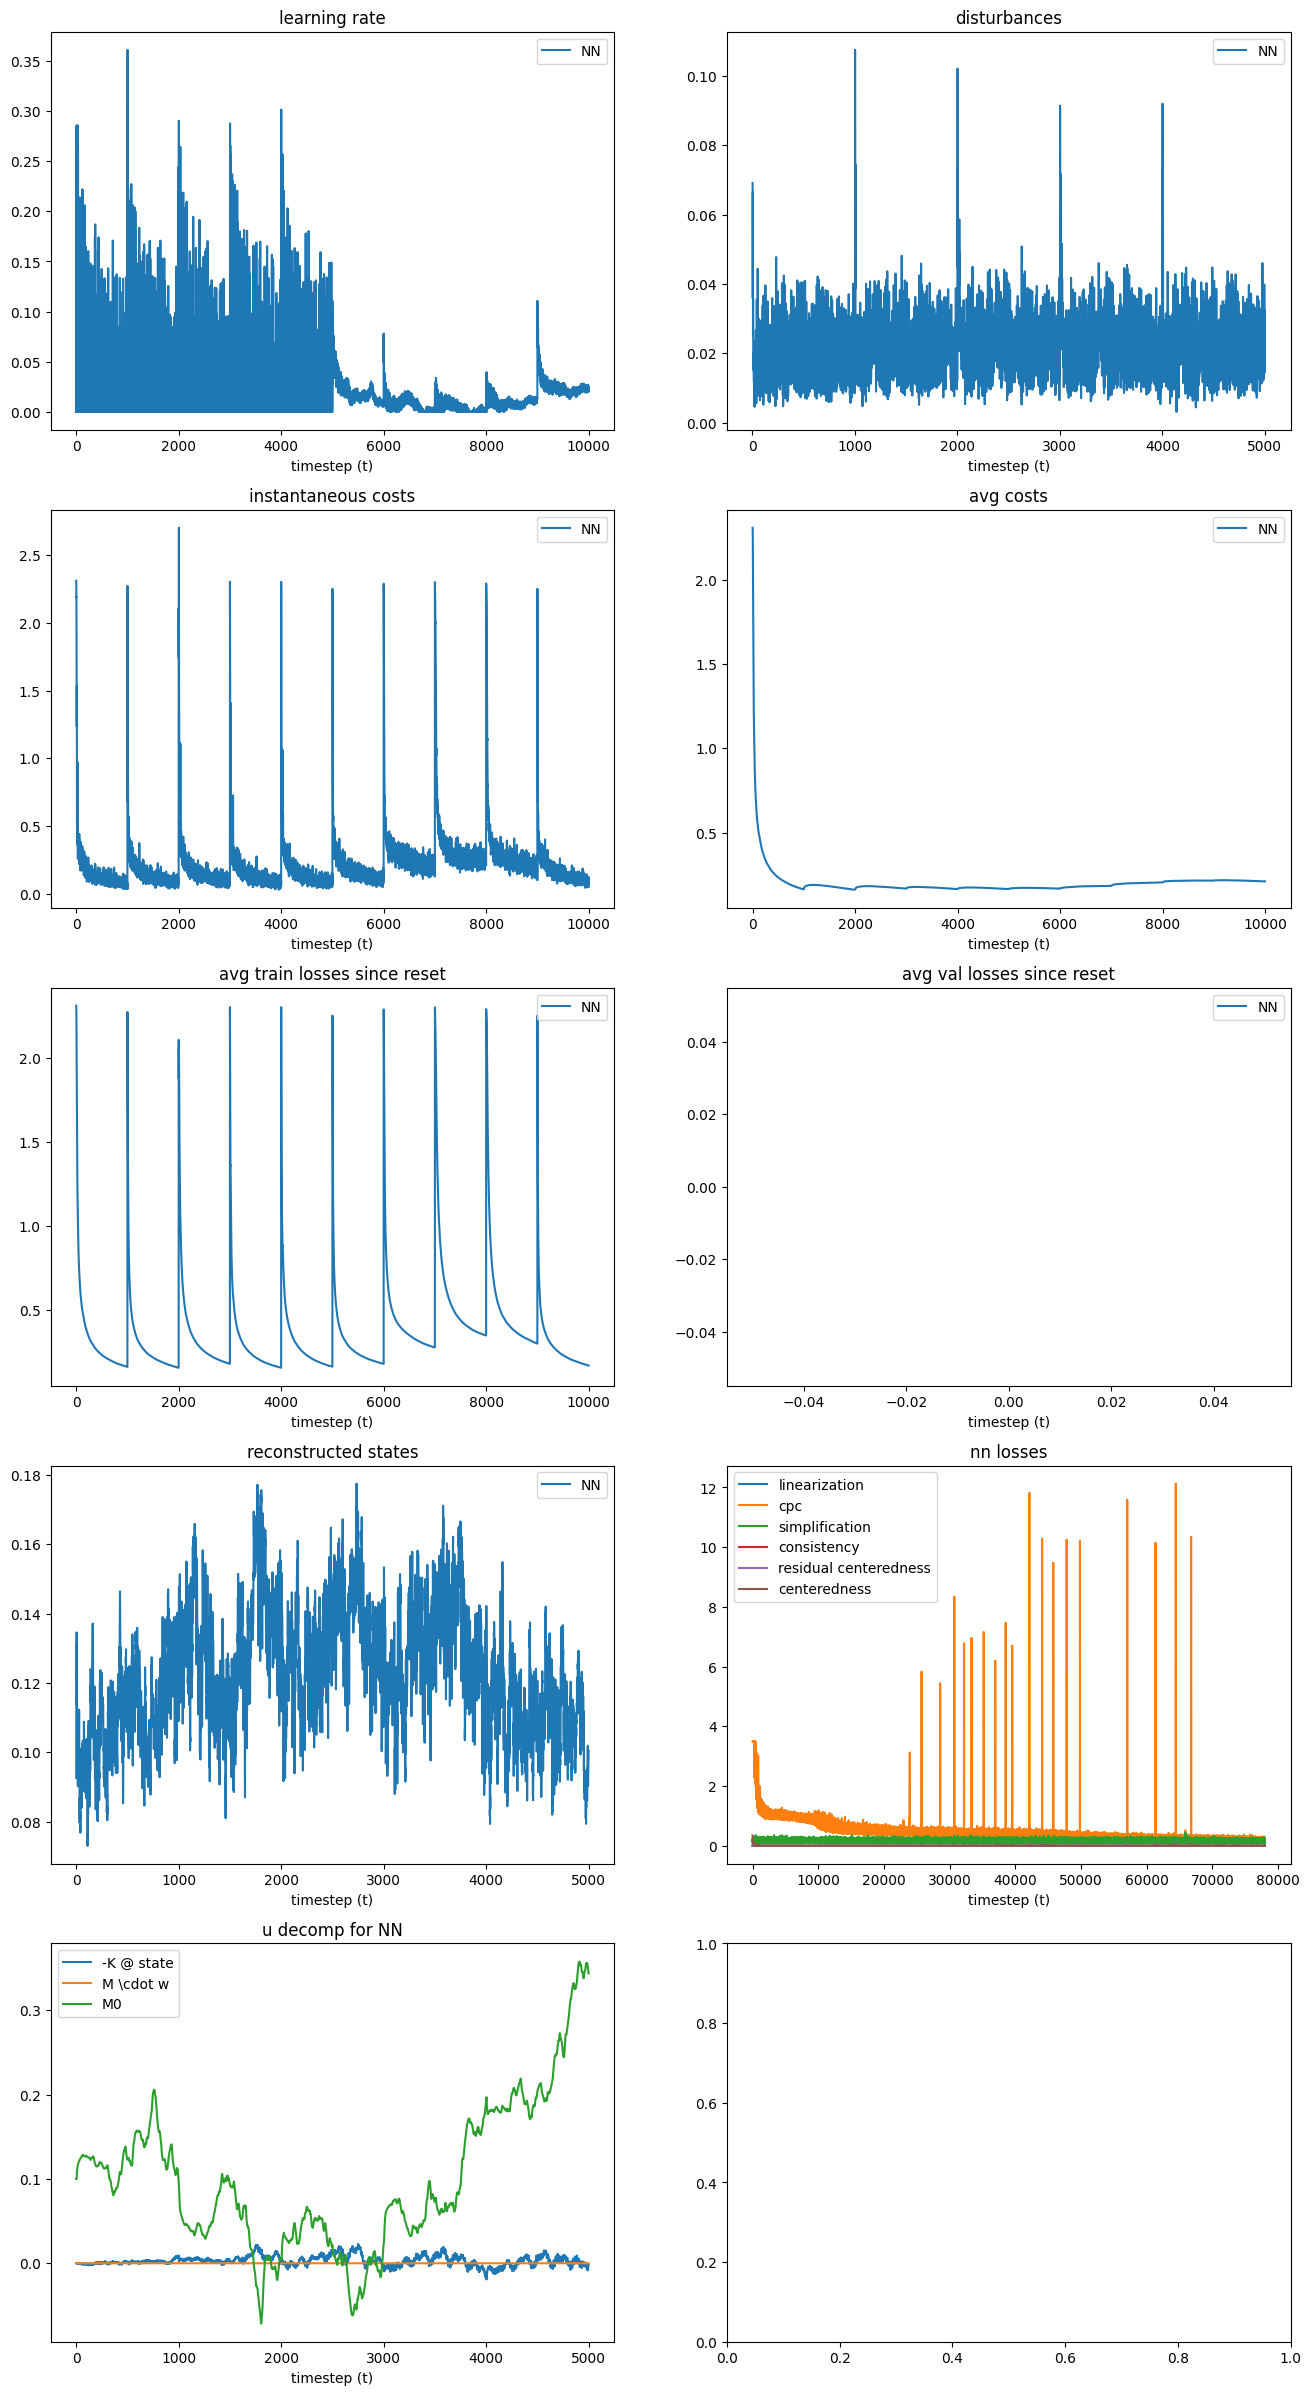

In [13]:
def plot(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 4
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            logging.warning('{} had no stats'.format(method))
            continue
            
        stats.plot(ax[0, 0], 'lrs', label=method)
        stats.plot(ax[1, 0], 'costs', label=method)
        stats.plot(ax[1, 1], 'costs', label=method, plot_cummean=True)
        stats.plot(ax[2, 0], 'avg train losses since reset', label=method)
        stats.plot(ax[2, 1], 'avg val losses since reset', label=method)        
        
        stats.plot(ax[3, 0], 'states', label=method, plot_norm=True)  # norm of the "state"
        from extravaganza.sysid import LOSS_WEIGHTS
        for k in LOSS_WEIGHTS.keys(): stats.plot(ax[3, 1], k, label=k)  # various nn losses
            
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method, plot_norm=True)
        idx = 0
        stats.plot(i_ax, '-K @ state', label='-K @ state', plot_idx=idx)
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w', plot_idx=idx)
        stats.plot(i_ax, 'M0', label='M0', plot_idx=idx)
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('learning rate'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('instantaneous costs'); _ax.legend()
    _ax = ax[1, 1]; _ax.set_title('avg costs'); _ax.legend(); ylim(_ax, 0, 10000)
    _ax = ax[2, 0]; _ax.set_title('avg train losses since reset'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('avg val losses since reset'); _ax.legend()
    _ax = ax[3, 0]; _ax.set_title('reconstructed states'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('nn losses'); _ax.legend()  
    pass
plot(experiment)

### Dynamic Plot

INFO: (RENDERER): rendering the stats of the following: ['NN']


AttributeError: 'Stats' object has no attribute 'get_render_fns'

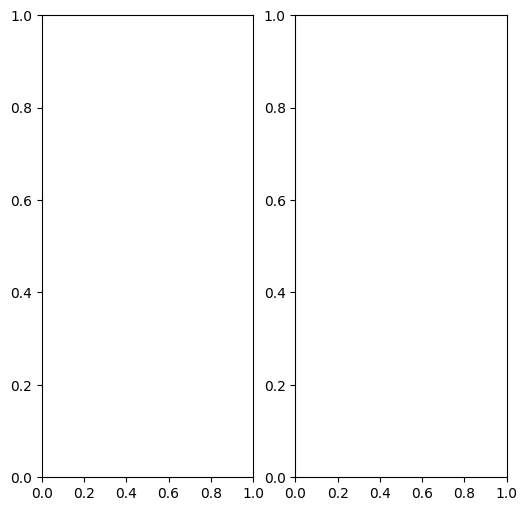

In [6]:
# dynamic plot
anim = render(experiment, 'lrs', 'train losses', sliderkey='lrs', save_path=None, duration=5)
vid = anim.to_html5_video()
HTML(vid)